In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as npz
import datetime as dt
from TrainingLogProcessor import TrainingLogProcessor
from oauth2client.service_account import ServiceAccountCredentials

In [6]:
scope = ["https://spreadsheets.google.com/feeds",
                 "https://www.googleapis.com/auth/drive"]
        # 認証情報を使ってクライアントを作成
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
creds

In [3]:
log_obj = TrainingLogProcessor()
log_obj.df.head()

,日付,種目,セット,重量[kg],回数[回],Volume
0,2024-09-19,バックスクワット,1,70,10,700
1,2024-09-19,バックスクワット,2,80,10,800
2,2024-09-19,バックスクワット,3,80,10,800
3,2024-09-19,ベンチプレス,1,50,10,500
4,2024-09-19,ベンチプレス,2,50,6,300


In [3]:
latest_df = log_obj.get_latest_volume()
latest_df.head()
training_menus = latest_df["種目"].unique()
training_menus

/Users/yudaitakahashi/Documents/Dev/LifeLog/TrainingLogProcessor.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  latest_df["Delta"] = latest_df["Total Volume"] - latest_df["Pre Volume"]


array(['ラットプルダウン', 'アーノルドプレス', 'コンベンショナルデッドリフト', 'ダンベルベンチプレス', 'バックスクワット',
       'ベンチプレス'], dtype=object)

# TotalVolumeの可視化

In [4]:
total_volume_df = log_obj.get_total_volume()
total_volume_df.head()
total_volume_df = total_volume_df.pivot(index="日付",
                                        columns="種目",
                                        values="Volume").reset_index()

KeyError: '種目'

In [39]:
total_volume_df

種目,日付,アーノルドプレス,コンベンショナルデッドリフト,ダンベルベンチプレス,バックスクワット,ベンチプレス,ラットプルダウン
0,2024-09-19,NaN,NaN,NaN,2300.0,1100.0,960.0
1,2024-09-21,NaN,1000.0,840.0,2400.0,NaN,1030.0
2,2024-09-23,600.0,NaN,1260.0,3500.0,NaN,NaN
3,2024-09-25,NaN,NaN,840.0,3660.0,1200.0,NaN
4,2024-09-29,NaN,1900.0,1600.0,3800.0,NaN,NaN


In [45]:

menu = training_menus[2]
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=total_volume_df["日付"],
                         y=total_volume_df[menu], 
                         connectgaps=True))

fig.update_xaxes(rangeslider={"visible":True}) # X軸に range slider を表示（下図参照）

# fig.update_yaxes(scaleanchor="x", scaleratio=1) # Y軸のスケールをX軸と同じに（plt.axis("equal")）

fig.update_layout(title=menu) # グラフタイトルを設定
fig.update_layout(font={"family":"Meiryo", "size":15}) # フォントファミリとフォントサイズを指定
# fig.u

displayed_day = 14
print(dt.datetime.today()-dt.timedelta(displayed_day))
fig.update_layout(template="seaborn",
                  xaxis_title="Date",
                  yaxis_title="Total Volume[kg]",
                  width=800,
                  height=600,
                  xaxis=dict(range=[dt.datetime.today() - dt.timedelta(days=displayed_day), dt.datetime.today()])
                  )
fig.show() 



2024-09-16 14:12:48.343411


## ContributionMapの作成

In [86]:
duration = 365

date_df = pd.DataFrame()
date_df["date"] = pd.date_range(dt.datetime.today() - dt.timedelta(days=duration),
                                dt.datetime.today())

date_df["date"] = pd.date_range(dt.date(2024, 1, 1),dt.date(2024, 12, 31))
date_df["date"] = date_df["date"].dt.floor('D') 


daily_volume_df = log_obj.df.groupby("日付")["Volume"].sum().reset_index()
daily_volume_df = daily_volume_df.rename(
    columns={"Volume" : "Total Volume"}
)

contribution_df = pd.merge(date_df, daily_volume_df, left_on="date",
                            right_on="日付", how="left")
contribution_df = contribution_df.fillna(0)
contribution_df.set_index('date', inplace=True)
## add data
contribution_df['month'] = pd.to_datetime(contribution_df.index).strftime('%m')
contribution_df['weekday'] = pd.to_datetime(contribution_df.index).strftime('%w')
contribution_df['week'] = pd.to_datetime(contribution_df.index).strftime('%U')
contribution_df

,日付,Total Volume,month,weekday,week
date,,,,,
2024-01-01,0,0.0,01,1,00
2024-01-02,0,0.0,01,2,00
2024-01-03,0,0.0,01,3,00
2024-01-04,0,0.0,01,4,00
2024-01-05,0,0.0,01,5,00
...,...,...,...,...,...
2024-12-27,0,0.0,12,5,51
2024-12-28,0,0.0,12,6,51
2024-12-29,0,0.0,12,0,52


In [90]:
contribution_map = contribution_df.pivot(index='weekday', columns='week', values='Total Volume').reset_index()
# contribution_map = contribution_df.pivot(index='weekday', columns='week', values='yymmdd').reset_index()
contribution_map.drop(['weekday'], axis=1, inplace=True)
contribution_map.fillna(0, inplace=True)
contribution_map

week,00,01,02,03,04,05,06,07,08,09,...,43,44,45,46,47,48,49,50,51,52
0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN


In [163]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Heatmap(
        z=contribution_map.values,  # ヒートマップの値
        xgap=4,  # X方向のグリッド間のギャップ
        ygap=4,  # Y方向のグリッド間のギャップ
        colorscale='Greens', # カラースケール
        showscale=False  # カラーバーを非表示（GitHub風に）
    ))

# x軸ラベルとして使用する月ごとのマーカー位置（週番号）
year = dt.datetime.today().strftime("%Y")
dates = pd.date_range(f'{year}-01-01', f'{year}-12-31')
monthes = date_df.strftime("%m")
weeks = date_df.strftime("%U").astype(int)+1
month_start_weeks = weeks[dates.is_month_start]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# x軸のカスタマイズ
fig.update_layout(
    width=900,
    height=280,
    template="seaborn",
    xaxis=dict(
        tickvals=month_start_weeks,  # ラベルを表示するxの値（週番号）
        ticktext=month_labels,  # 表示する月の名前
        tickmode='array' , # ラベルを手動設定
        scaleanchor="y",   # y軸に対してx軸をスケール固定
        showgrid=False,    # グリッド線を非表示
        constrain="domain" # レイアウト全体に対してx軸のサイズを固定
    ),
    yaxis = dict(
        showgrid=False,    # グリッド線を非表示
        scaleanchor="x",   # x軸に対してy軸をスケール固定
        tickvals=[0, 1, 2, 3, 4, 5, 6],
        ticktext=['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'],  # x軸ラベル
        tickmode='array' , # ラベルを手動設定
        constrain="domain" # レイアウト全体に対してx軸のサイズを固定
    ),
    # margin=dict(l=20, r=20, t=20, b=20),
    title="Contribution Map"
)


In [106]:
year = dt.datetime.today().strftime("%Y")

dates = pd.date_range(f'{year}-01-01', f'{year}-12-31')
monthes = date_df.strftime("%m")
weeks = date_df.strftime("%U").astype(int)+1
month_start_weeks = weeks[dates.is_month_start]
month_start_weeks

Index([1, 5, 9, 14, 18, 22, 27, 31, 36, 40, 44, 49], dtype='int64')

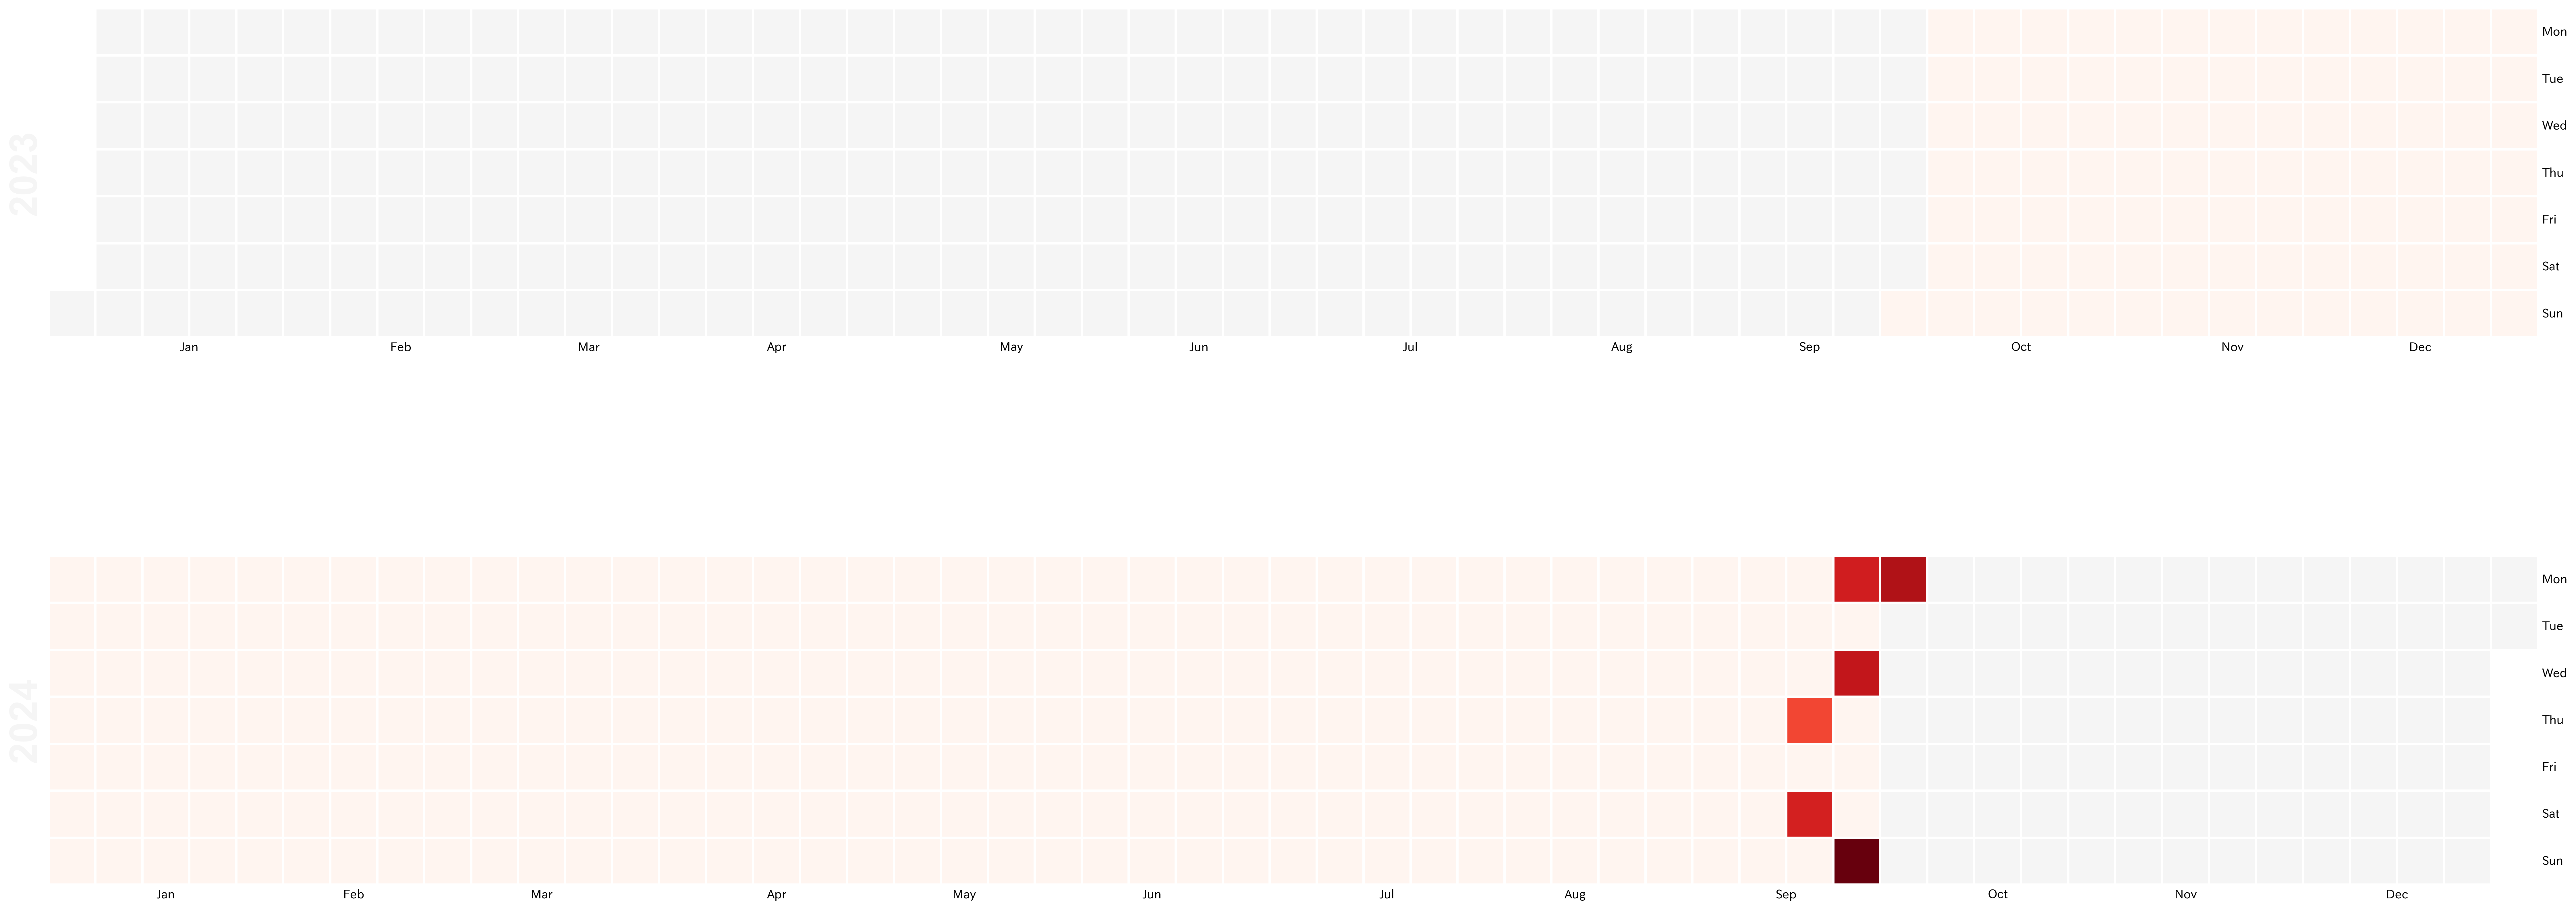

In [12]:
import calmap
fig, ax = calmap.calendarplot(contribution_map,
                              linewidth=1.5, 
                              fig_kws=dict(figsize=(30, 15), dpi=300))